本文将介绍计算 51.3毫升 0.131mol/L 乙酸与 0.0953mol/L NaOH溶液的滴定曲线的方法。首先，导入库。

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

单质子酸和碱的滴定曲线分为三部分。对于弱酸与强碱的滴定来说，这三个部分分别是添加NaOH到半中和点（HA等于A$^{-}$），从半中和点到中和点（A$^{-}$大于HA），以及酸碱中和之后的部分。记录三个过程中所消耗的NaOH的量很重要。因此，在开始编程之前，让我们先输入达到中和点和半中和点时所添加的NaOH的体积吧！（中和点的时候弱酸的摩尔数*正好*等于强碱的摩尔数）

In [12]:
acid_VolI = 0.0513
acid_ConI = 0.131

acid_MolI = acid_VolI * acid_ConI
print("滴定前乙酸有", "{:.3}".format(acid_MolI), "mol。")

base_Con = 0.0953
eq_pt = acid_MolI/base_Con

print("到达中和点时消耗了", "{:.3}".format(eq_pt), "L", base_Con, "mol/L NaOH。")

half_eq_pt = eq_pt/2
print("到达半中和点时消耗了", "{:.3}".format(half_eq_pt), "L", base_Con, "mol/L NaOH。")


滴定前乙酸有 0.00672 mol。
到达中和点时消耗了 0.0705 L 0.0953 mol/L NaOH。
到达半中和点时消耗了 0.0353 L 0.0953 mol/L NaOH。


现在我们得到了到达半中和点时所消耗的NaOH的量。接下来，我们需要生成一个数组，其中包含了一系列从初始到半中和点添加的NaOH的体积。同理，再生成一个数组，其中包含了一系列从半中和点到中和点添加的NaOH的体积。

In [4]:
datapts = 100

xrange = np.linspace(0,half_eq_pt,num=datapts,endpoint=False,retstep=True)
PreHalfEqVols = xrange[0]
VolStep = xrange[1]

xrange = np.linspace(half_eq_pt,eq_pt,num=datapts,endpoint=False,retstep=True)
PostHalfEqVols = xrange[0]
VolStep2 = xrange[1]


现在我们有了两个数组，它将作为滴定曲线的x轴，我们需要对每个点进行平衡计算。从滴定开始到半中和点（直到加入的乙酸比乙酸盐多），下面是该平衡：

$$\textrm{CH}_{3}\textrm{COOH}_{(aq)} + \textrm{H}_{2}\textrm{O} \rightarrow \textrm{H}_{3}\textrm{O}^{+}_{(aq)} + \textrm{CH}_{3}\textrm{COO}^{-}_{(aq)} \qquad \textrm{K}_{a} = 1.76 \textrm{x} 10^{-5}$$

对于每个点的平衡计算，三段式中乙酸初始摩尔数将是乙酸的初始摩尔数*减去*添加的NaOH的摩尔数，乙酸盐的初始摩尔数将*等于*添加的NaOH的摩尔数，总体积将是酸溶液的初始体积*加上*添加的NaOH的体积。为了求解平衡，我们需要求解一个二次方程，所以让我们首先从 AgCl 溶解度notebook中复制二次方程求解器，并对其进行测试。

In [5]:
def quad_solve(a, b, c):
    discrim = np.sqrt(b**2 - 4 * a * c)
    sol1 = (-b + discrim)/(2 * a)
    sol2 = (-b - discrim)/(2 * a)
    return [sol1,sol2]

solutions = quad_solve(1,1.76E-5,-0.131*1.76E-5)
conc_H3O = solutions[0]
pH = -np.log10(conc_H3O)

print("该溶液的初始pH值为：", "{:.3}".format(pH))

该溶液的初始pH值为： 2.82


好像运行成功了（当然，你可以自己算一下看看是否正确）。
现在让我们计算这个过程中的pH值。
注意浓度的计算需要考虑到总体积的变化！

In [6]:
equilibConst = 1.76E-5
H3O_water = 1E-7
init_baseConc = (PreHalfEqVols*base_Con)/(PreHalfEqVols+acid_VolI)
init_acidConc = (acid_ConI*acid_VolI-PreHalfEqVols*base_Con)/(PreHalfEqVols+acid_VolI)

pre_solutions = quad_solve(1,init_baseConc+equilibConst+H3O_water,init_baseConc*H3O_water-init_acidConc*equilibConst)
preH3Oconc = pre_solutions[0]
pre_pH = -np.log10(preH3Oconc)

让我们检查一下计算出来的pH值是否正确。

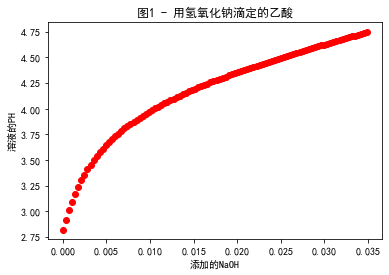

In [10]:
plt.plot(PreHalfEqVols, pre_pH, 'ro')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.title("图1 - 用氢氧化钠滴定的乙酸")
plt.xlabel('添加的NaOH的体积')
plt.ylabel('溶液的PH')
plt.show()

图表具有我们预期的形状，并且pH的范围是我们期望的，看起来我们做对了！

现在，按照上面的方法计算溶液从半中和点到当量点的pH值。注意！因为溶液中乙酸盐的含量比乙酸更高，所以主要反应是：

$$\textrm{CH}_{3}\textrm{COO}^{-}_{(aq)} + \textrm{H}_{2}\textrm{O} \rightarrow \textrm{OH}^{-}_{(aq)} + \textrm{CH}_{3}\textrm{COOH}_{(aq)} \qquad \textrm{K}_{b} = \frac{\textrm{K}_{w}}{\textrm{K}_{a}} = 5.67 \textrm{x} 10^{-10}$$

请注意，我已经创建了表示OH$^{-}$ 含量的列表（名为 PostHalfEqVols ）。同时请注意，随着乙酸的浓度变小，来自水电离的OH$^{-}$将变得很重要，因此您需要将其考虑在在计算中（我在上面并没有真正考虑它）。

现在你已经计算了从半中和点到中和点溶液的pH值，请将所得的数据点与上面的数据点相结合，并用图标画出来，x轴为添加的NaOH的体积，纵轴为溶液的PH值。其中半中和点前画成红色，半中和点画成蓝色。

最后，计算从中和点到添加0.15LNaOH 的pH值。这应该比前文更为直观，因为只需要考虑NaOH的OH$^{-}$。将得到的数据点与上面的数据点相结合，绘制整个滴定曲线，红色显示到半中和点的数据，蓝色显示从半中和点到中和点的数据，中和点之后的点用绿色来表示。